In [1]:
import os
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from PIL import Image
from pathlib import Path

from sklearn.metrics import classification_report

In [2]:
### UTILITY VARIABLES ###

SHAPE = (224, 224,)
batch_size = 32

train_dir = Path('./monkey_dataset/training')
test_dir = Path('./monkey_dataset/validation')

In [3]:
### READ AND CORRECT LABEL FILE ###

labels = pd.read_csv("./monkey_dataset/monkey_labels.txt")
labels.columns = [c.strip() for c in labels.columns]
labels['Label'] = labels['Label'].str.strip()
labels['Common Name'] = labels['Common Name'].str.strip()
labels['Latin Name'] = labels['Latin Name'].str.strip()
map_labels = labels['Common Name'][:5].to_dict()

print(map_labels)
labels

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset'}


,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


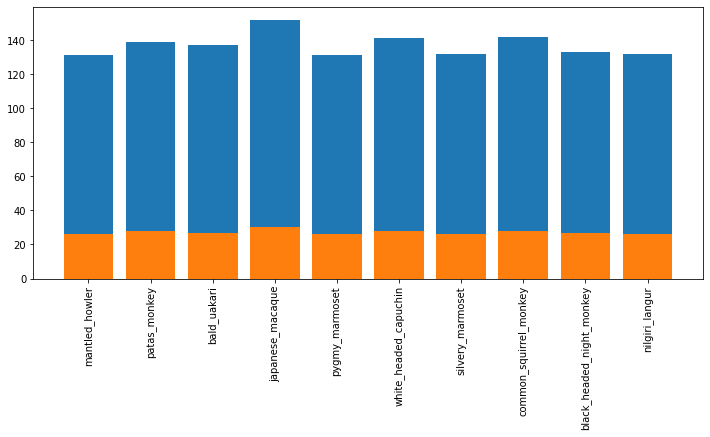

In [4]:
### TRAIN/TEST DISTRIBUTION ###

plt.figure(figsize=(12,5))

plt.bar(range(len(labels['Train Images'])), labels['Train Images'])
plt.bar(range(len(labels['Validation Images'])), labels['Validation Images'])
plt.xticks(range(len(labels['Common Name'])), labels['Common Name'], rotation=90)

np.set_printoptions(False)

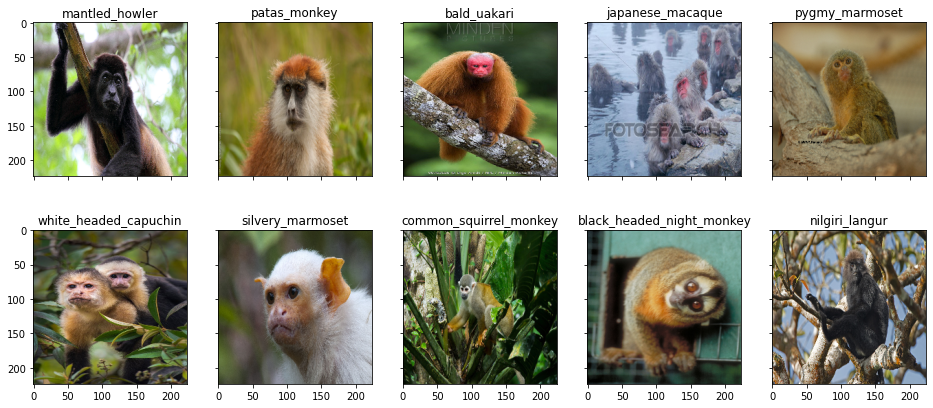

In [5]:
### SHOW SAMPLES FROM VARIOUS SPECIES ###

f, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize = (16,7))

for ax, label, name in zip(axes.ravel(), labels['Label'], labels['Common Name']):
    img = np.random.choice(os.listdir('./monkey_dataset/training/'+label))
    img = cv2.imread('./monkey_dataset/training/'+label+'/'+img)
    img = cv2.resize(img, SHAPE)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(name)

In [6]:
### ESTABILSH TRAIN/TEST GENERATOR ###

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
### GET TRAIN DATA + AUGMENTATION ###

train_generator = train_datagen.flow_from_directory(train_dir, target_size=SHAPE, class_mode='categorical', 
                                                    subset='training', shuffle=True, seed=33,
                                                    classes=['n1', 'n2', 'n3', 'n4', 'n5'])

train_num = train_generator.samples

Found 506 images belonging to 5 classes.


In [8]:
### GET VALIDATION DATA + AUGMENTATION ###

validation_generator = train_datagen.flow_from_directory(train_dir, target_size=SHAPE, class_mode='categorical', 
                                                    subset='validation', shuffle=False, seed=33,
                                                    classes=['n1', 'n2', 'n3', 'n4', 'n5'])

### AUGMENT 100 TIMES EVERY SINGLE IMAGE ###
rep=100
validation_num = validation_generator.samples
image_valid, label_valid = [], []

for i, (batch, label) in enumerate(validation_generator):
    
    image_valid.append(batch)
    label_valid.append(label)
        
    if i == ((validation_num // batch_size)+1)*rep-1:
        break
        
image_valid = np.vstack(image_valid)
label_valid = np.argmax(np.vstack(label_valid), axis=1)

print(image_valid.shape, label_valid.shape)

Found 55 images belonging to 5 classes.
(5500, 224, 224, 3) (5500,)


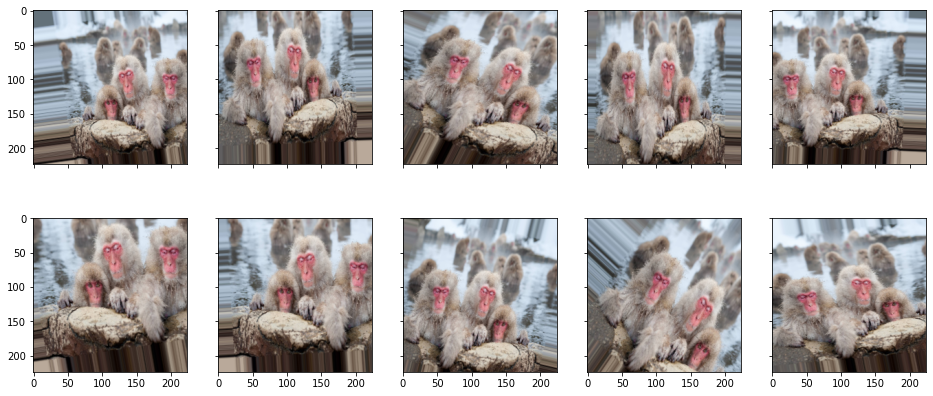

In [9]:
### SHOW AUGMENTED IMAGES ###

f, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize = (16,7))

random_id = np.random.randint(0, validation_num)
img_ids = np.arange(random_id, ((validation_num - random_id)+random_id)*10, validation_num)
for ax, img_id in zip(axes.ravel(), img_ids):
    ax.imshow(image_valid[img_id])

In [10]:
### GET TEST DATA ###

test_generator = test_datagen.flow_from_directory(test_dir, target_size=SHAPE, 
                                                  class_mode='categorical', classes=['n1', 'n2', 'n3', 'n4', 'n5'])

test_num = test_generator.samples

image_test, label_test = [], []
for i in range((test_num // batch_size)+1):
    x,y = test_generator.next()
    image_test.append(x)
    label_test.append(y)
        
image_test = np.vstack(image_test)
label_test = np.argmax(np.vstack(label_test), axis=1)

print(image_test.shape, label_test.shape)

Found 139 images belonging to 5 classes.
(139, 224, 224, 3) (139,)


In [11]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

    
def get_model():
    
    set_seed(33)
    
    inp = Input(shape=SHAPE+tuple([3]))

    x = Conv2D(32, (3, 3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x, training = True)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x, training = True)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x, training = True)

    out = Dense(5, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [12]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)

model = get_model()
model.fit(train_generator, steps_per_epoch= train_num / batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_num / batch_size, 
          callbacks=[es], verbose = 2)

Epoch 1/50
16/15 - 38s - loss: 1.6136 - accuracy: 0.2530 - val_loss: 1.5664 - val_accuracy: 0.2182
Epoch 2/50
16/15 - 41s - loss: 1.5161 - accuracy: 0.3142 - val_loss: 1.3393 - val_accuracy: 0.4182
Epoch 3/50
16/15 - 42s - loss: 1.4046 - accuracy: 0.4111 - val_loss: 1.2926 - val_accuracy: 0.4182
Epoch 4/50
16/15 - 37s - loss: 1.3024 - accuracy: 0.4348 - val_loss: 1.2449 - val_accuracy: 0.5455
Epoch 5/50
16/15 - 39s - loss: 1.2365 - accuracy: 0.5079 - val_loss: 1.0723 - val_accuracy: 0.6545
Epoch 6/50
16/15 - 37s - loss: 1.1286 - accuracy: 0.5672 - val_loss: 1.0443 - val_accuracy: 0.5455
Epoch 7/50
16/15 - 38s - loss: 1.0823 - accuracy: 0.5692 - val_loss: 1.0314 - val_accuracy: 0.5455
Epoch 8/50
16/15 - 36s - loss: 1.0362 - accuracy: 0.6186 - val_loss: 0.8915 - val_accuracy: 0.6364
Epoch 9/50
16/15 - 40s - loss: 0.9315 - accuracy: 0.6502 - val_loss: 0.8846 - val_accuracy: 0.6727
Epoch 10/50
16/15 - 38s - loss: 0.8607 - accuracy: 0.6976 - val_loss: 0.7859 - val_accuracy: 0.7091
Epoch 11/

In [13]:
### COMPUTE PREDICTIONS ###

pred_prob_valid = model.predict(image_valid)
pred_valid = np.argmax(pred_prob_valid, axis=1)

pred_prob_test = model.predict(image_test)
pred_test = np.argmax(pred_prob_test, axis=1)

In [14]:
print(classification_report([map_labels[label] for label in label_test], [map_labels[label] for label in pred_test]))

                  precision    recall  f1-score   support

     bald_uakari       0.87      0.67      0.75        30
japanese_macaque       0.79      0.88      0.84        26
  mantled_howler       0.73      0.79      0.76        28
    patas_monkey       0.87      1.00      0.93        27
  pygmy_marmoset       0.88      0.82      0.85        28

        accuracy                           0.83       139
       macro avg       0.83      0.83      0.83       139
    weighted avg       0.83      0.83      0.82       139



# UNCERTAINTY WITH STANDARD THRESHOLD

In [15]:
### GET PROBABILITY DISTRIBUTIONS ON VALIDATION SET ###

diz_prob = {}
diz_prob_correct, diz_prob_mistake = {}, {}

for i in np.unique(label_test):
    diz_prob_correct[i] = []
    diz_prob_mistake[i] = []
    diz_prob[i] = []


for i,j,prob in zip(label_valid, pred_valid, pred_prob_valid):
    diz_prob[i].append(prob[j])
    
    if i == j:
        diz_prob_correct[j].append(prob[i])
    else:
        diz_prob_mistake[j].append(prob[j])

In [16]:
### ESTABLISH THRESHOLD FOR EACH CLASS ###

thresh_valid = {}
for i in range(5):
    thresh_valid[i] = np.quantile(diz_prob[i], 0.1)
    
thresh_valid

{0: 0.41956658363342286,
 1: 0.5470804214477539,
 2: 0.42139427065849305,
 3: 0.48039963841438293,
 4: 0.5399843215942383}

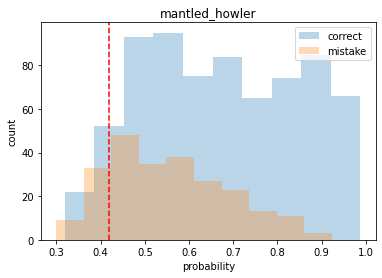

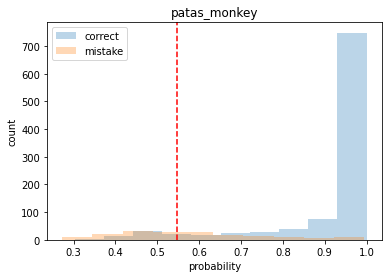

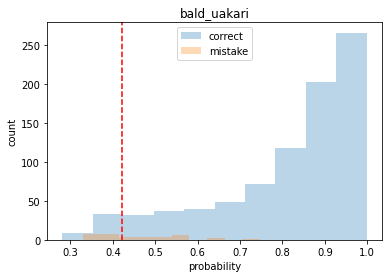

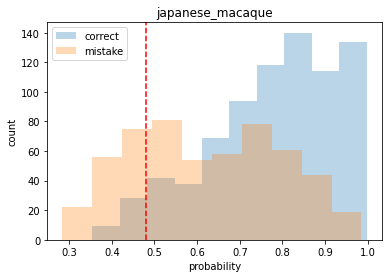

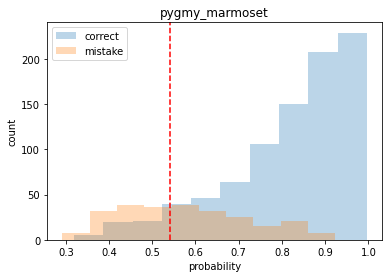

In [17]:
### PLOT PROBABILITY DISTRIBUTIONS ###

for i in range(5):
    
    plt.hist(diz_prob_correct[i], bins=10, alpha=0.3, label='correct')
    plt.hist(diz_prob_mistake[i], bins=10, alpha=0.3, label='mistake')
    plt.axvline(thresh_valid[i], color='red', linestyle='--')
    plt.legend(); plt.xlabel('probability'); plt.ylabel('count'); plt.title(map_labels[i])
    plt.show()

np.set_printoptions(False)

In [18]:
### COMPUTE PREDICTIONS WITH THRESHOLD ###

count = 0
label_thresh, pred_thresh = [], []

for pred, pred_prob, label in zip(pred_test, pred_prob_test, label_test):

    if max(pred_prob) < thresh_valid[int(pred)]:
        count+=1
    else:
        pred_thresh.append(map_labels[pred])
        label_thresh.append(map_labels[label])
        
count # not classificable

12

In [19]:
print(classification_report(label_thresh, pred_thresh))

                  precision    recall  f1-score   support

     bald_uakari       0.86      0.72      0.78        25
japanese_macaque       0.79      0.88      0.83        25
  mantled_howler       0.78      0.78      0.78        27
    patas_monkey       0.90      1.00      0.95        26
  pygmy_marmoset       0.91      0.83      0.87        24

        accuracy                           0.84       127
       macro avg       0.85      0.84      0.84       127
    weighted avg       0.84      0.84      0.84       127



# UNCERTAINTY WITH BAYESIAN THEORY

In [20]:
### REACTIVATE DROPOUTS AND ITERATE PREDICTIONS ###

pred_bayes_dist = []
rep = 100

for i in tqdm(range(0,rep)):
    pred_bayes_dist.append(model.predict(image_test))
    
pred_bayes_dist = np.transpose(np.stack(pred_bayes_dist), (1,0,2))
pred_bayes_dist.shape

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:40<00:00,  4.01s/it]


(139, 100, 5)

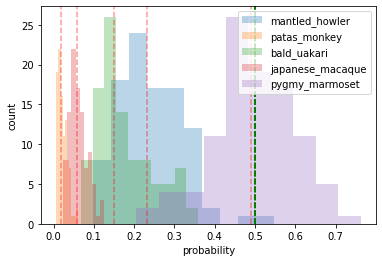

In [21]:
### VISUALIZE PROBABILITY DISTRIBUTIONS FOR A SPECIFIC TEST IMAGE ###

test_id = 4

for i in range(5):
    
    plt.hist(pred_bayes_dist[test_id][:,i], alpha=0.3, label=map_labels[i])
    
    plt.axvline(np.quantile(pred_bayes_dist[test_id][:,i], 0.5), color='red', linestyle='--', alpha=0.4)
    plt.axvline(0.5, color='green', linestyle='--')
    plt.xlabel('probability'); plt.ylabel('count'); plt.legend()
    
    # plt.show()
    
np.set_printoptions(False)

In [22]:
### COMPUTE PREDICTIONS WITH THRESHOLD ###

count = 0
label_bayes, pred_bayes = [], []

for pred, label in zip(pred_bayes_dist, label_test):
    q_pred = np.quantile(pred, 0.5, axis=0)
    
    if len([q_p for q_p in q_pred if q_p>0.5])==0:
        count+=1
    else:
        pred_bayes.append(map_labels[np.argmax(q_pred)])
        label_bayes.append(map_labels[label])

count # not classificable

26

In [23]:
print(classification_report(label_bayes, pred_bayes))

                  precision    recall  f1-score   support

     bald_uakari       0.89      0.77      0.83        22
japanese_macaque       0.83      0.87      0.85        23
  mantled_howler       0.84      0.84      0.84        19
    patas_monkey       0.93      1.00      0.96        27
  pygmy_marmoset       0.91      0.91      0.91        22

        accuracy                           0.88       113
       macro avg       0.88      0.88      0.88       113
    weighted avg       0.88      0.88      0.88       113

